In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Dataset Citation

<b> Link: https://ai.stanford.edu/~amaas/data/sentiment/ </b>

@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}
<br> <br>

### Import Libraries

In [2]:
# import libraries

import re
import glob
import time
import pickle
import string
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
from sklearn import utils
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn.utils import shuffle
import sklearn.metrics as metrics
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

warnings.filterwarnings('ignore')

### Import Training Datasets

In [3]:
# define function to transform txt files to dataframes

def process(file_list):
    
    review_list = []
    
    for file in file_list:
        temp = open(file, 'r')
        review = temp.read()
        temp.close()
        review_list.append(review)
    
    return review_list

In [4]:
# Training Dataset
# import positive dataset and negative dataset
# Courtesy: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

pfile_list = glob.glob("train/pos/*.txt")
nfile_list = glob.glob("train/neg/*.txt")

print("total positive (training) reviews: ", len(pfile_list))
print("total negative (training) reviews: ", len(nfile_list))


pdf = pd.DataFrame(process(pfile_list), columns=['reviews'])
pdf['label'] = 1

ndf = pd.DataFrame(process(nfile_list), columns=['reviews'])
ndf['label'] = 0

total positive (training) reviews:  12500
total negative (training) reviews:  12500


In [5]:
# Exploratory Data Analysis

frame = [pdf, ndf]
df1 = pd.concat(frame)

print(df1['label'].value_counts())
print('\n')
print(df1.info())

1    12500
0    12500
Name: label, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 12499
Data columns (total 2 columns):
reviews    25000 non-null object
label      25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 585.9+ KB
None


In [6]:
# Testing Dataset
# import positive dataset and negative dataset
# Courtesy: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

ptest_list = glob.glob("test/pos/*.txt")
ntest_list = glob.glob("test/neg/*.txt")

print("total positive (training) reviews: ", len(ptest_list))
print("total negative (training) reviews: ", len(ntest_list))

p_test = pd.DataFrame(process(ptest_list), columns=['reviews'])
p_test['label'] = 1

n_test = pd.DataFrame(process(ntest_list), columns=['reviews'])
n_test['label'] = 0

total positive (training) reviews:  12500
total negative (training) reviews:  12500


In [7]:
# Exploratory Data Analysis

frame = [p_test, n_test]
df_test = pd.concat(frame)
print(df_test['label'].value_counts())
print('\n')
print(df_test.info())

1    12500
0    12500
Name: label, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 12499
Data columns (total 2 columns):
reviews    25000 non-null object
label      25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 585.9+ KB
None


### Text Pre-Processing

In [8]:
# Pre-Requisite 1: Stopwords

# lengthy way of removing single character from the text
stopwords_dict = stopwords.words('english')
char_stopwords = ['a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 
                 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stopwords_dict.extend(char_stopwords)

# Pre-Requisite 2: Lemmetization
# Courtesy of Gaurav Gupta : https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None


def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [9]:
# Text Pre-Processing Function (Stemming)
# Decision 01 - Remove numerical value, simply text

# MultiProcessing
print("CPU available: ", multiprocessing.cpu_count())

st = PorterStemmer()

def preprocess_func(text):
    text = text.lower()
    text = re.compile(r'<[^>]+>').sub('', text) # remove html tags
    text = re.compile("[^a-zA-Z ]").sub('', text) # remove special character
    text = re.sub(r'\s+', ' ', text) # remove extra space           
    text = re.compile(r'\b(' + r'|'.join(stopwords_dict) + r')\b\s*').sub('', text) # remove stopwords
    text = lemmatize_sentence(text)
    return " ".join([st.stem(i) for i in text.split()])


# Function for MultiProcessing
def func(temp):
    temp = preprocess_func(temp)
    return temp

CPU available:  72


In [10]:
def cv_performance(clf, X, y, k=5):
    
    accuracy  = []
    precision = []
    recall    = []
    f1_list   = []
    rocauc    = []
    
    skf = StratifiedKFold(n_splits=k, random_state=None)
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        
        accuracy.append(accuracy_score(y_val, y_pred))
        precision.append(precision_score(y_val, y_pred))
        recall.append(recall_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))
        rocauc.append(roc_auc_score(y_val, y_pred))
    
    print("Validation Accuracy Score   : ", np.array(accuracy).mean())
    print("Validation Precision Score  : ", np.array(precision).mean())
    print("Validation Recall Score     : ", np.array(recall).mean())
    print("Validation F1-Score         : ", np.array(f1_list).mean())
    print("Validation ROC-AUC Score    : ", np.array(rocauc).mean())

    return np.array(accuracy).mean()

In [11]:
# Test Accuracy Function

def test_accuracy(clf, X_train, y_train, X_test, y_test):

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print("y Testing    : ")
    print(collections.Counter(y_test))
    
    print("y Prediction : ")
    print(collections.Counter(y_pred))
    
    print("Testing Accuracy Score   : ", accuracy_score(y_test, y_pred))   
    print("Testing ROC-AUC Score    : ", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix ")
    print(confusion_matrix(y_test, y_pred))
    
    return y_pred

## Text Pre-Processing

In [12]:
start_time = time.time()
review_list = df1['reviews'].values.tolist()
print(len(review_list))

p = Pool(72)
processed_list = p.map(func, review_list)
print("time : ", ((time.time() - start_time)/60), " mins")
print('Text Pre-Processing Done.')

25000
time :  0.15209068854649863  mins
Text Pre-Processing Done.


# Version 2.1 - Feature Hashing, Monogram

In [22]:
# Try : 500, 5000, 15000, 25000 
# Version 2.1 - Feature Hashing (Monogram)
# Logistic Regression 

from sklearn.feature_extraction.text import HashingVectorizer

# Version 2.1A - Monogram, Feature Hashing - 500

mono_500     = HashingVectorizer(n_features=500)
mono_500_bow = mono_500.fit_transform(np.array(processed_list)) # bow: bag-of-words
df211          = pd.DataFrame(mono_500_bow.toarray(), columns=range(1,501))

print(df211.shape)

# Prepare Data for Training | Validation Purpose

y211 = df1["label"].copy()
X211 = df211.copy()

print(y211.shape)
print(X211.shape)

# Logistic Regression

from sklearn.linear_model import LogisticRegression
    
lr_acc_list = [] 
start_time   = time.time()
C_param_range = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X211, y211, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

(25000, 500)
(25000,)
(25000, 500)
parameter :  0.5
Validation Accuracy Score   :  0.78096
Validation Precision Score  :  0.7756659797695731
Validation Recall Score     :  0.7905599999999999
Validation F1-Score         :  0.7830340633579163
Validation ROC-AUC Score    :  0.78096
time :  0.012374536196390788  mins
parameter :  0.6
Validation Accuracy Score   :  0.7812399999999999
Validation Precision Score  :  0.7764826464275332
Validation Recall Score     :  0.78984
Validation F1-Score         :  0.7830992525857512
Validation ROC-AUC Score    :  0.7812399999999999
time :  0.024928136666615804  mins
parameter :  0.7
Validation Accuracy Score   :  0.78152
Validation Precision Score  :  0.7769095832375578
Validation Recall Score     :  0.7898400000000001
Validation F1-Score         :  0.7833158273157579
Validation ROC-AUC Score    :  0.78152
time :  0.0388973871866862  mins
parameter :  0.8
Validation Accuracy Score   :  0.78144
Validation Precision Score  :  0.7765283627886344
Validation

Text(0, 0.5, 'Cross-Validated Accuracy')

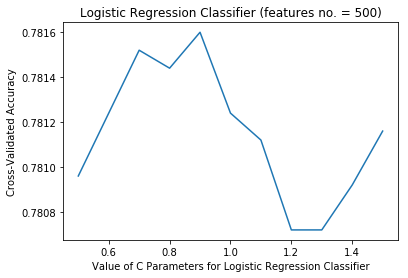

In [23]:
# Plot Accuracy (Logistic Regression)

plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (features no. = 500)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

In [27]:
# Version 2.1B - Monogram, Feature Hashing - 5000

mono_5000     = HashingVectorizer(n_features=5000)
mono_5000_bow = mono_5000.fit_transform(np.array(processed_list)) # bow: bag-of-words
df212          = pd.DataFrame(mono_5000_bow.toarray(), columns=range(1,5001))

print(df212.shape)

# Prepare Data for Training | Validation Purpose

y212 = df1["label"].copy()
X212 = df212.copy()

print(y212.shape)
print(X212.shape)

# Logistic Regression

from sklearn.linear_model import LogisticRegression
    
lr_acc_list = [] 
start_time   = time.time()
C_param_range = [3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X212, y212, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

(25000, 5000)
(25000,)
(25000, 5000)
parameter :  3.1
Validation Accuracy Score   :  0.85224
Validation Precision Score  :  0.8433337692178364
Validation Recall Score     :  0.8652
Validation F1-Score         :  0.8541169065891119
Validation ROC-AUC Score    :  0.8522399999999999
time :  0.159234885374705  mins
parameter :  3.2
Validation Accuracy Score   :  0.85232
Validation Precision Score  :  0.8432490109607735
Validation Recall Score     :  0.8655200000000001
Validation F1-Score         :  0.8542293274795782
Validation ROC-AUC Score    :  0.85232
time :  0.2914297024408976  mins
parameter :  3.3
Validation Accuracy Score   :  0.85224
Validation Precision Score  :  0.8431183609881089
Validation Recall Score     :  0.8655200000000001
Validation F1-Score         :  0.8541603786915044
Validation ROC-AUC Score    :  0.8522400000000001
time :  0.42262210448582965  mins
parameter :  3.4
Validation Accuracy Score   :  0.85244
Validation Precision Score  :  0.8436629626309947
Validation Re

Text(0, 0.5, 'Cross-Validated Accuracy')

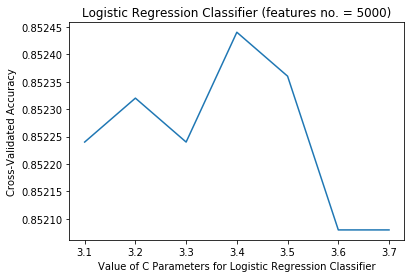

In [28]:
plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (features no. = 5000)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

In [30]:
mono_15000     = HashingVectorizer(n_features=15000)
mono_15000_bow = mono_15000.fit_transform(np.array(processed_list)) # bow: bag-of-words
df213          = pd.DataFrame(mono_15000_bow.toarray(), columns=range(1,15001))

print(df213.shape)

# Prepare Data for Training | Validation Purpose

y213 = df1["label"].copy()
X213 = df213.copy()

print(y213.shape)
print(X213.shape)

# Logistic Regression

from sklearn.linear_model import LogisticRegression
    
lr_acc_list = [] 
start_time   = time.time()
C_param_range = [3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X213, y213, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

(25000, 15000)
(25000,)
(25000, 15000)
parameter :  3.5
Validation Accuracy Score   :  0.86192
Validation Precision Score  :  0.8521350716786432
Validation Recall Score     :  0.87584
Validation F1-Score         :  0.863795507951018
Validation ROC-AUC Score    :  0.86192
time :  0.8426752328872681  mins
parameter :  3.6
Validation Accuracy Score   :  0.862
Validation Precision Score  :  0.852321621644889
Validation Recall Score     :  0.8757600000000001
Validation F1-Score         :  0.8638508166236859
Validation ROC-AUC Score    :  0.862
time :  2.1609667976697287  mins
parameter :  3.7
Validation Accuracy Score   :  0.86208
Validation Precision Score  :  0.852456250967899
Validation Recall Score     :  0.87576
Validation F1-Score         :  0.8639199520204237
Validation ROC-AUC Score    :  0.86208
time :  3.0018794178962707  mins
parameter :  3.8
Validation Accuracy Score   :  0.86192
Validation Precision Score  :  0.8523581785803904
Validation Recall Score     :  0.87552
Validation 

Text(0, 0.5, 'Cross-Validated Accuracy')

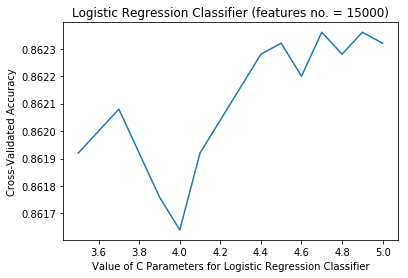

In [31]:
plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (features no. = 15000)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

In [33]:
mono_25000     = HashingVectorizer(n_features=25000)
mono_25000_bow = mono_25000.fit_transform(np.array(processed_list)) # bow: bag-of-words
df214          = pd.DataFrame(mono_25000_bow.toarray(), columns=range(1,25001))

print(df214.shape)

# Prepare Data for Training | Validation Purpose

y214 = df1["label"].copy()
X214 = df214.copy()

print(y214.shape)
print(X214.shape)

# Logistic Regression

from sklearn.linear_model import LogisticRegression
    
lr_acc_list = [] 
start_time   = time.time()
C_param_range = [4.5, 5, 5.5, 6, 6.5, 7]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X214, y214, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

(25000, 25000)
(25000,)
(25000, 25000)
parameter :  4.5
Validation Accuracy Score   :  0.8652
Validation Precision Score  :  0.8559109903973708
Validation Recall Score     :  0.87832
Validation F1-Score         :  0.8669299192902136
Validation ROC-AUC Score    :  0.8652
time :  1.4280835509300231  mins
parameter :  5
Validation Accuracy Score   :  0.86536
Validation Precision Score  :  0.8560603325497795
Validation Recall Score     :  0.8784799999999999
Validation F1-Score         :  0.8670853934555702
Validation ROC-AUC Score    :  0.8653599999999999
time :  2.8040224353472394  mins
parameter :  5.5
Validation Accuracy Score   :  0.86476
Validation Precision Score  :  0.8557291075754441
Validation Recall Score     :  0.8775200000000001
Validation F1-Score         :  0.8664443893238734
Validation ROC-AUC Score    :  0.86476
time :  4.2147242824236555  mins
parameter :  6
Validation Accuracy Score   :  0.86484
Validation Precision Score  :  0.8560310828749904
Validation Recall Score    

Text(0, 0.5, 'Cross-Validated Accuracy')

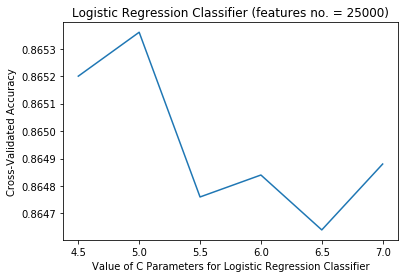

In [34]:
plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (features no. = 25000)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

# Version 2.2 - Feature Hashing, Bigram

In [15]:
# Version 2.2 - Bigram, Feature Hashing - 25000

from sklearn.feature_extraction.text import HashingVectorizer
bi_25000     = HashingVectorizer(n_features=25000, ngram_range=(1, 2))
bi_25000_bow = bi_25000.fit_transform(np.array(processed_list)) # bow: bag-of-words
df22          = pd.DataFrame(bi_25000_bow.toarray(), columns=range(1,25001))

print(df22.shape)

# Prepare Data for Training | Validation Purpose

y22 = df1["label"].copy()
X22 = df22.copy()

print(y22.shape)
print(X22.shape)

# Logistic Regression

from sklearn.linear_model import LogisticRegression
    
lr_acc_list = [] 
start_time   = time.time()
C_param_range = [6, 7, 8, 9, 10]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X22, y22, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

(25000, 25000)
(25000,)
(25000, 25000)
parameter :  6
Validation Accuracy Score   :  0.85932
Validation Precision Score  :  0.8490024778784314
Validation Recall Score     :  0.87416
Validation F1-Score         :  0.8613577887264108
Validation ROC-AUC Score    :  0.8593200000000001
time :  1.728625484307607  mins
parameter :  7
Validation Accuracy Score   :  0.8582000000000001
Validation Precision Score  :  0.8482349152552215
Validation Recall Score     :  0.87256
Validation F1-Score         :  0.8601875027874987
Validation ROC-AUC Score    :  0.8582000000000001
time :  3.2083672523498534  mins
parameter :  8
Validation Accuracy Score   :  0.8577600000000001
Validation Precision Score  :  0.8479418124883695
Validation Recall Score     :  0.87192
Validation F1-Score         :  0.8597197168736499
Validation ROC-AUC Score    :  0.85776
time :  4.557532982031504  mins
parameter :  9
Validation Accuracy Score   :  0.8578399999999999
Validation Precision Score  :  0.8484037505468328
Validatio

Text(0, 0.5, 'Cross-Validated Accuracy')

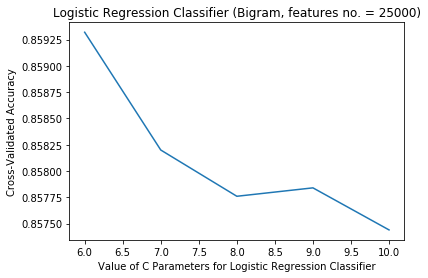

In [16]:
plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (Bigram, features no. = 25000)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

# Version 2.3 - Feature Hashing, Trigram

In [19]:
# Version 2.3 - Trigram, Feature Hashing - 25000

from sklearn.feature_extraction.text import HashingVectorizer
tri_25000     = HashingVectorizer(n_features=25000, ngram_range=(1, 3))
tri_25000_bow = tri_25000.fit_transform(np.array(processed_list)) # bow: bag-of-words
df23          = pd.DataFrame(tri_25000_bow.toarray(), columns=range(1,25001))

print(df23.shape)

# Prepare Data for Training | Validation Purpose

y23 = df1["label"].copy()
X23 = df23.copy()

print(y23.shape)
print(X23.shape)

# Logistic Regression

from sklearn.linear_model import LogisticRegression
    
lr_acc_list = [] 
start_time   = time.time()
C_param_range = [3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 
                 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 
                 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X23, y23, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

(25000, 25000)
(25000,)
(25000, 25000)
parameter :  3.0
Validation Accuracy Score   :  0.85048
Validation Precision Score  :  0.8381853799358301
Validation Recall Score     :  0.8687199999999999
Validation F1-Score         :  0.853135624376151
Validation ROC-AUC Score    :  0.8504800000000001
time :  1.7430797974268595  mins
parameter :  3.1
Validation Accuracy Score   :  0.8505199999999999
Validation Precision Score  :  0.8384069923756068
Validation Recall Score     :  0.86848
Validation F1-Score         :  0.8531331442953498
Validation ROC-AUC Score    :  0.8505199999999999
time :  3.2468074480692546  mins
parameter :  3.2
Validation Accuracy Score   :  0.85048
Validation Precision Score  :  0.8385501461028286
Validation Recall Score     :  0.86816
Validation F1-Score         :  0.853055120960476
Validation ROC-AUC Score    :  0.85048
time :  5.083431649208069  mins
parameter :  3.3
Validation Accuracy Score   :  0.85036
Validation Precision Score  :  0.8384636201755236
Validation Re

Validation Accuracy Score   :  0.85048
Validation Precision Score  :  0.8400295261857692
Validation Recall Score     :  0.86592
Validation F1-Score         :  0.8527403206159159
Validation ROC-AUC Score    :  0.85048
time :  55.03231064478556  mins


Text(0, 0.5, 'Cross-Validated Accuracy')

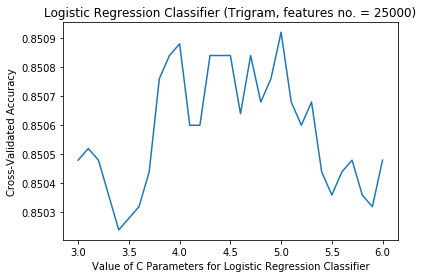

In [20]:
plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (Trigram, features no. = 25000)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

In [13]:
# Testing

start_time = time.time()
test_list = df_test['reviews'].values.tolist()
processed_tlist = p.map(func, test_list)
print("time : ", ((time.time() - start_time)/60), " mins")
print('Text Pre-Processing (Test) Done.')

time :  0.10009789069493612  mins
Text Pre-Processing (Test) Done.


In [17]:
# Test (Mono)
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression

mono_25000     = HashingVectorizer(n_features=25000)
mono_25000_bow = mono_25000.fit_transform(np.array(processed_list)) # bow: bag-of-words
df_mono        = pd.DataFrame(mono_25000_bow.toarray(), columns=range(1,25001))
y_mono = df1["label"].copy()
X_mono = df_mono.copy()

mono_25000_tbow = mono_25000.fit_transform(np.array(processed_tlist)) # bow: bag-of-words
df_tmono        = pd.DataFrame(mono_25000_tbow.toarray(), columns=range(1,25001))
y_tmono = df_test["label"].copy()
X_tmono = df_tmono.copy()

mono_clf = LogisticRegression(penalty='l2', C=5, random_state=42)
mono_clf.fit(X_mono, y_mono)
y_pred1 = mono_clf.predict(X_tmono)
print("Accuracy : ", accuracy_score(y_tmono, y_pred1))

Accuracy :  0.86812


In [18]:
# Test (Bi)

bi_25000     = HashingVectorizer(n_features=25000, ngram_range=(1, 2))
bi_25000_bow = bi_25000.fit_transform(np.array(processed_list)) # bow: bag-of-words
df_bi        = pd.DataFrame(bi_25000_bow.toarray(), columns=range(1,25001))
y_bi = df1["label"].copy()
X_bi = df_bi.copy()

bi_25000_tbow = bi_25000.fit_transform(np.array(processed_tlist)) # bow: bag-of-words
df_tbi        = pd.DataFrame(bi_25000_tbow.toarray(), columns=range(1,25001))
y_tbi = df_test["label"].copy()
X_tbi = df_tbi.copy()

bi_clf = LogisticRegression(penalty='l2', C=6, random_state=42)
bi_clf.fit(X_bi, y_bi)
y_pred2 = bi_clf.predict(X_tbi)
print("Accuracy : ", accuracy_score(y_tbi, y_pred2))

Accuracy :  0.86296


In [19]:
# Test (Tri)

tri_25000     = HashingVectorizer(n_features=25000, ngram_range=(1, 3))
tri_25000_bow = tri_25000.fit_transform(np.array(processed_list)) # bow: bag-of-words
df_tri        = pd.DataFrame(tri_25000_bow.toarray(), columns=range(1,25001))
y_tri = df1["label"].copy()
X_tri = df_tri.copy()

tri_25000_tbow = tri_25000.fit_transform(np.array(processed_tlist)) # bow: bag-of-words
df_ttri        = pd.DataFrame(tri_25000_tbow.toarray(), columns=range(1,25001))
y_ttri = df_test["label"].copy()
X_ttri = df_ttri.copy()

tri_clf = LogisticRegression(penalty='l2', C=5, random_state=42)
tri_clf.fit(X_tri, y_tri)
y_pred3 = bi_clf.predict(X_ttri)
print("Accuracy : ", accuracy_score(y_ttri, y_pred3))

Accuracy :  0.85256


In [ ]:
# The End 